In [17]:

!apt updateapt update
!pip install mdbtools-dev
!apt-get install mdbtools
!pip install pandas pyodbc
!pip install pymssql
!pip install tempfile2
import warnings
warnings.filterwarnings('ignore')

E: Invalid operation updateapt
ERROR: Could not find a version that satisfies the requirement mdbtools-dev (from versions: none)
ERROR: No matching distribution found for mdbtools-dev
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
mdbtools is already the newest version (1.0.0+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import sys
sys.path.append('/content/drive/MyDrive/Dev/py2/')
import numpy as np

import pandas as pd
from google.colab import files
import os
import subprocess
from io import StringIO  # StringIOを正しくインポート
import model.utility.k_analysis_util as k_a_util
from IPython.display import display

from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

import model.utility.k_analysis_util as k_analysis_util

In [20]:
db_path = "/content/drive/MyDrive/Dev/Kjvan/kjdb_predict_result.accdb"


In [21]:

cmd = f"select * from PredictResults"
print(cmd)

select * from PredictResults


In [22]:
df_re = k_analysis_util.execute_mdb_sql(db_path, cmd)

Query output saved to: /tmp/tmp3gjpm48m.txt


In [23]:
# import pandas as pd
# import matplotlib.pyplot as plt


# # bt_place、bt_distance、bt_track_cdでグループ化
# grouped = df_re.groupby(['pr_program_id', 'pr_race'])

# # 各グループごとに箱ひげ図を描画
# for group_name, group_df in grouped:
#     plt.figure()
#     group_df.drop([ 'pr_program_id', 'pr_race', 'pr_horse_id', 'pr_odds', 'pr_vote', 'pr_rank'], axis=1).boxplot()
#     plt.title(f'Group: {group_name}')
#     plt.show()


In [ ]:
#prompt: 以下のコードで行の表示を'pr_horse_id'-'pr_vote'の表記に変更してください
import warnings
from google.colab import drive
import sys
import numpy as np
import pandas as pd
from google.colab import files
import os
import subprocess
from io import StringIO  # StringIOを正しくインポート
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import model.utility.k_analysis_util as k_analysis_util

# bt_place、bt_distance、bt_track_cdでグループ化
grouped = df_re.groupby(['pr_program_id', 'pr_race'])

# 各グループごとにヒートマップを描画
for (program_id, race), group_df in grouped:
    #group_df['pr_rank'] = group_df['pr_rank'].replace('00', '99')
    query = f"pr_rank.astype('int') != 0"
    group_df2 = group_df.query(query, engine='python')
    # pr_rankでソート
    sorted_group_df = group_df2.sort_values('pr_rank')


    # 'pr_horse_id'-'pr_vote' の列を作成
    sorted_group_df['pr_horse_id-pr_vote'] = sorted_group_df['pr_horse_id'].astype(str) + '-' + sorted_group_df['pr_vote'].astype(str).str.zfill(2)  # 2桁の0詰め

    # ヒートマップのデータ作成
    # 'pr_horse_id' を 'pr_horse_id-pr_vote' に変更
    heatmap_data = sorted_group_df[['pr_horse_id-pr_vote', 'pr_h1_pred', 'pr_h2_pred', 'pr_h3_pred', 'pr_h4_pred', 'pr_hE_pred']]
    heatmap_data = heatmap_data.set_index('pr_horse_id-pr_vote')
    heatmap_data = heatmap_data.rename(columns={
        'pr_h1_pred': 'mlp',
        'pr_h2_pred': 'cat',
        'pr_h3_pred': 'amt',
        'pr_h4_pred': 'bld',
        'pr_hE_pred': 'ens',
    })

    plt.figure(figsize=(10, 6))  # 図のサイズ調整
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", center=0) # center=0でグレーを中央に
    plt.title(f'Heatmap for Program ID: {program_id}, Race: {race}')
    plt.show()


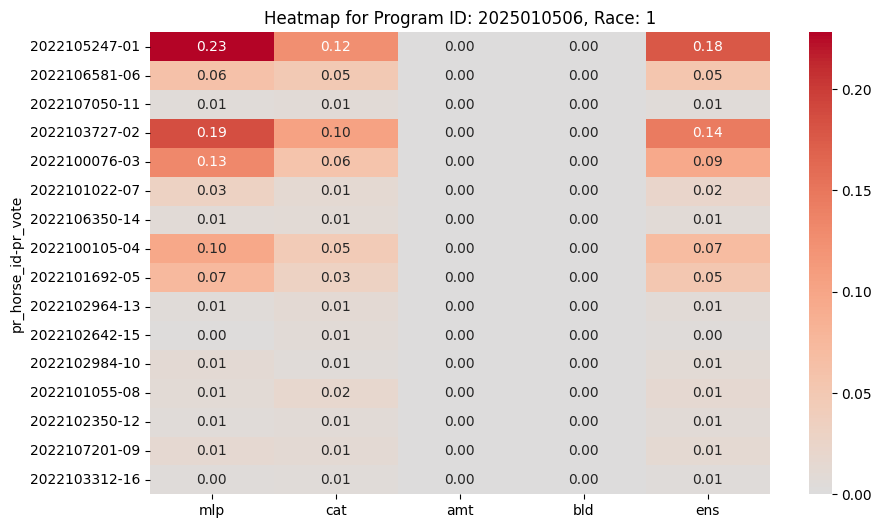

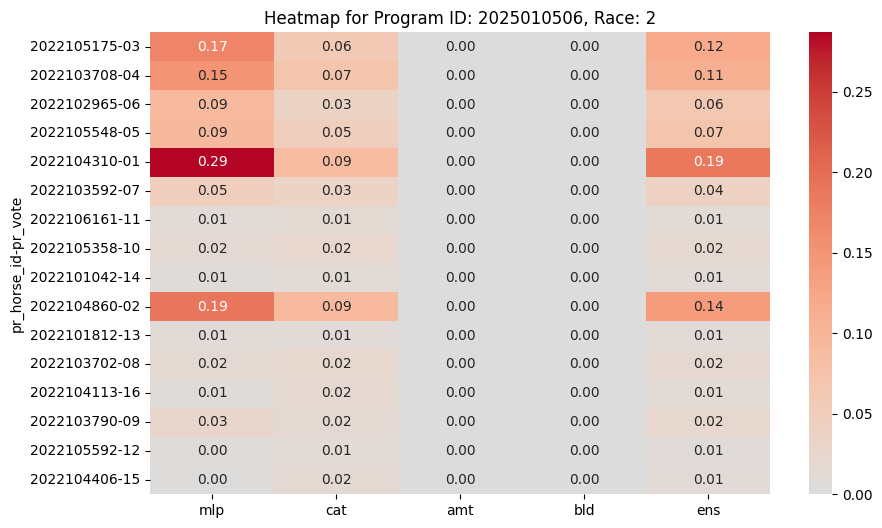

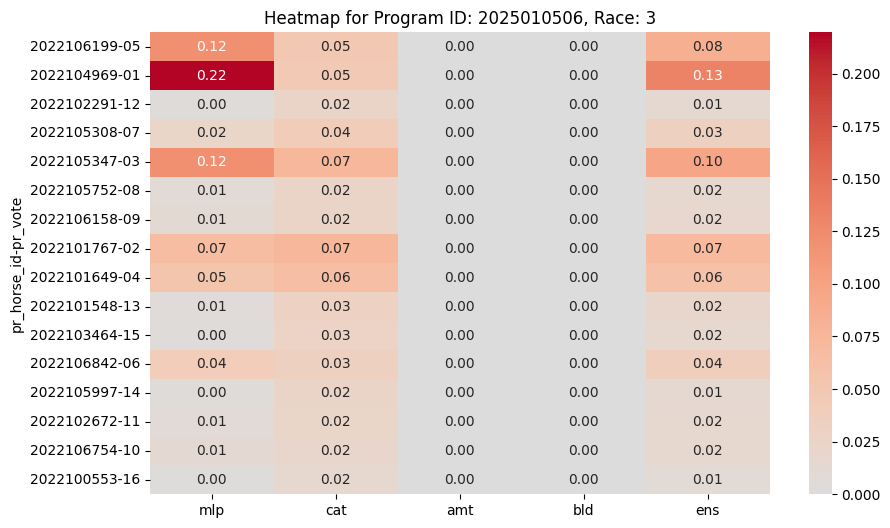

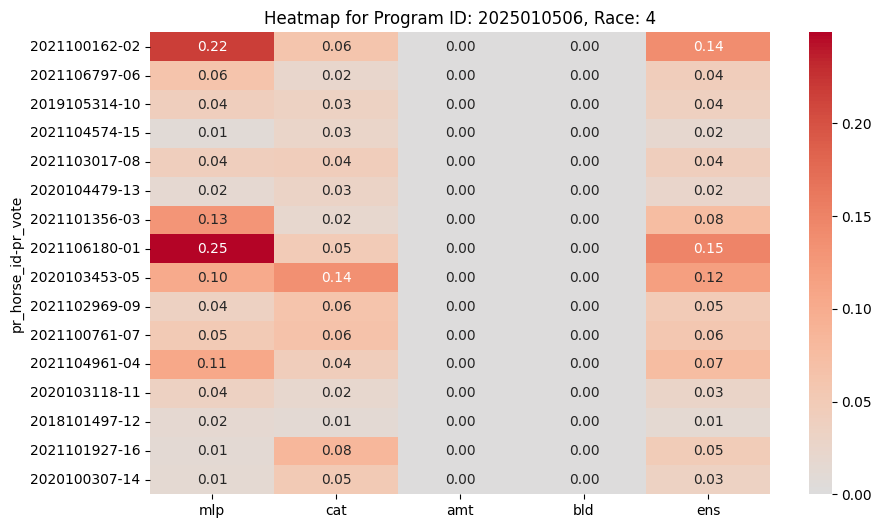

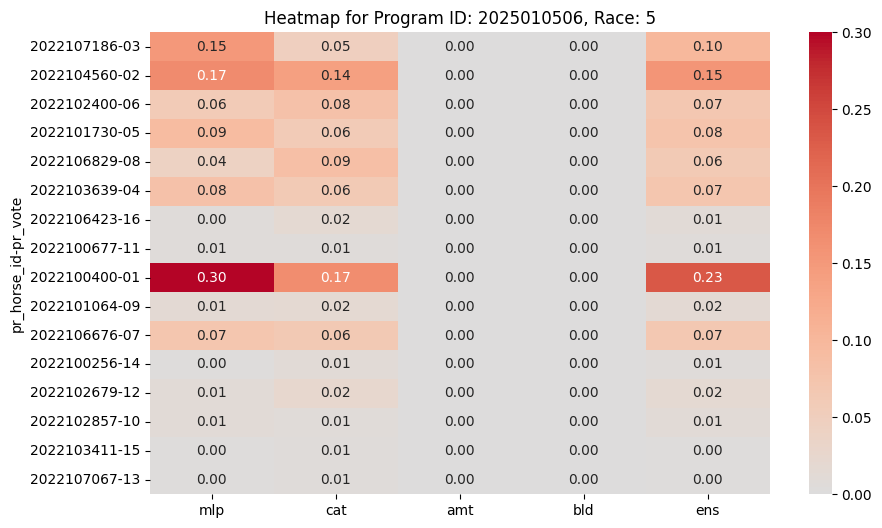

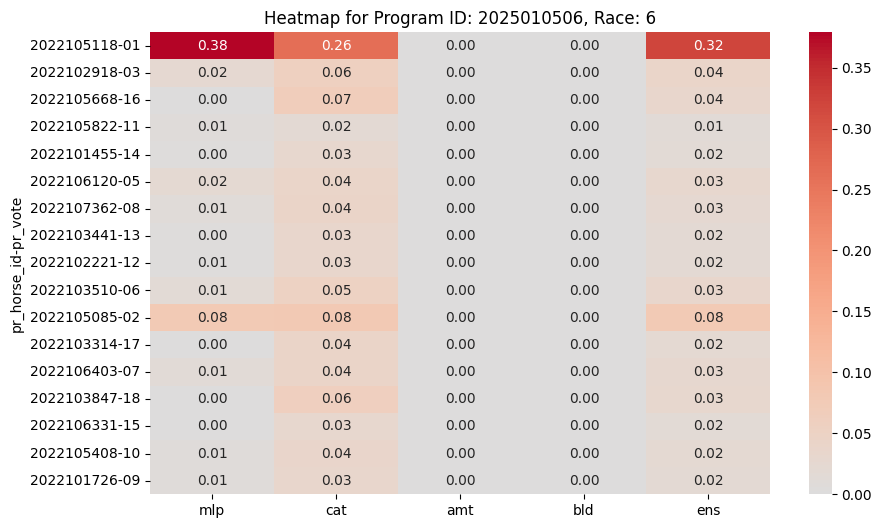

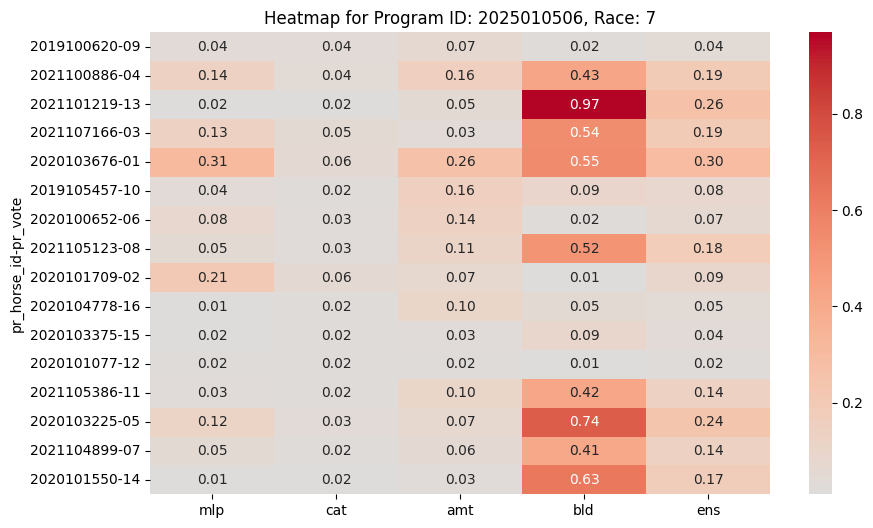

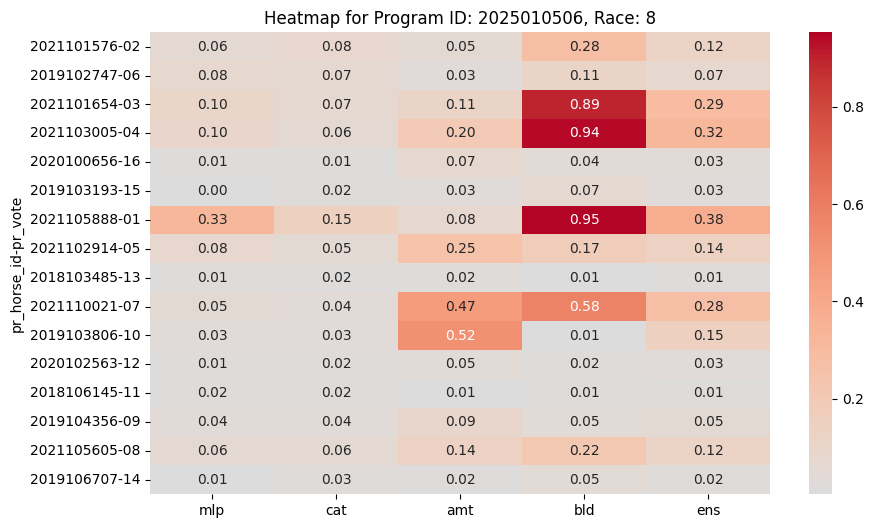

In [ ]:
import warnings
from google.colab import drive
import sys
import numpy as np
import pandas as pd
from google.colab import files
import os
import subprocess
from io import StringIO
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import model.utility.k_analysis_util as k_analysis_util

# 表示オプションの設定
pd.set_option('display.max_colwidth', 5)  # 各列の最大表示幅を10に設定

# bt_place、bt_distance、bt_track_cdでグループ化
grouped = df_re.groupby(['pr_program_id', 'pr_race'])

# 各グループごとにヒートマップを描画
for (program_id, race), group_df in grouped:
    query = f"pr_rank.astype('int') != 0"
    group_df2 = group_df.query(query, engine='python')
    # pr_rankでソート
    sorted_group_df = group_df2.sort_values('pr_rank')

    # 'pr_horse_id-pr_vote' の列を作成
    sorted_group_df['pr_horse_id-pr_vote'] = sorted_group_df['pr_horse_id'].astype(str) + '-' + sorted_group_df['pr_vote'].astype(str).str.zfill(2)  # 2桁の0詰め

    # ヒートマップのデータ作成
    heatmap_data = sorted_group_df[['pr_horse_id-pr_vote', 'pr_h1_pred', 'pr_h2_pred', 'pr_h3_pred', 'pr_h4_pred', 'pr_hE_pred']]
    heatmap_data = heatmap_data.set_index('pr_horse_id-pr_vote')
    heatmap_data = heatmap_data.rename(columns={
        'pr_h1_pred': 'mlp',
        'pr_h2_pred': 'cat',
        'pr_h3_pred': 'amt',
        'pr_h4_pred': 'bld',
        'pr_hE_pred': 'ens',
    })

    plt.figure(figsize=(10, 6))  # 図のサイズ調整
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", center=0) # center=0でグレーを中央に
    plt.title(f'Heatmap for Program ID: {program_id}, Race: {race}')
    plt.show()
